In [12]:
from collections import defaultdict, deque
from random import random

import gymnasium as gym
import numpy as np
import random
import seaborn as sns
import pandas as pd

In [13]:
class Agent:
    def __init__(
            self,
            start_epsilon=1,
            epsilon_decay=0.9,
            epsilon_cut=0.1,
            alpha=0.01,
            gamma=1,
            number_of_actions=6
                 ):
        self.epsilon = start_epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_cut = epsilon_cut
        self.alpha = alpha
        self.gamma = gamma
        self.na = number_of_actions
        
        self.Q = defaultdict(lambda: np.zeros(self.na))
        
    def select_action(self, state):
        r = random.random()
        if r > self.epsilon:
            return np.argmax(self.Q[state])
        else:
            return random.randint(0, self.na-1)
        
    def step(self, state, action, reward, next_state, done):
        if not done:
            self.Q[state][action] += self.alpha * (
                reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action]
            )
        else:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
            self.epsilon *= self.epsilon_decay
            if self.epsilon_cut is not None:
                self.epsilon = max(self.epsilon, self.epsilon_cut)

In [14]:
# взял из интернета
optimal_sarsa_max = {
    'alpha': 0.2512238484351891,
    'epsilon_cut': 0,
    'epsilon_decay': 0.8888782926665223,
    'start_epsilon': 0.9957089031634627,
    'gamma': 0.7749915552696941
}

num_episodes = 30000
window = 100

env = gym.make('Taxi-v3')
optimal_sarsa_max['number_of_actions'] = env.action_space.n
agent = Agent(**optimal_sarsa_max)

In [15]:
avg_rewards = deque(maxlen=num_episodes)
best_avg_reward = -np.inf
reward_threshold = 9.7

sampled_rewards = deque(maxlen=window)

for episode in range(1, num_episodes+1):
    state, info = env.reset()
    sampled_reward = 0
    
    while True:
        # agent select an action
        action = agent.select_action(state)
        # agent permorms the selected action
        next_state, reward, done, _, _ = env.step(action)
        # agent performs internal updates based on sampled experience
        agent.step(state, action, reward, next_state, done)
        # update the sampled reward
        sampled_reward += reward
        # update the state
        state = next_state
        if done:
            # save final sampled reward
            sampled_rewards.append(sampled_reward)
            break
    # every 100 episodes compile average reward
    if episode >= 100:
        avg_reward = np.mean(sampled_rewards)
        avg_rewards.append(avg_reward)
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            
    # monitor
    print(
        "\rEpisode {}/{} || Best average reward {}".format(
            episode, num_episodes, best_avg_reward
        ), end=""
    )
    
    # check if task is solved 
    if best_avg_reward >= reward_threshold:
        print(
            '\nEnvironment solved in {} episodes.'.format(episode),
            end=""
        )
        break

Episode 30000/30000 || Best average reward 8.852

In [16]:
data = pd.DataFrame(list(avg_rewards), columns=['reward'])
data.loc[:,'episode'] = range(0,len(list(avg_rewards)))
data.loc[:,'type'] = 'Sarsa Max'

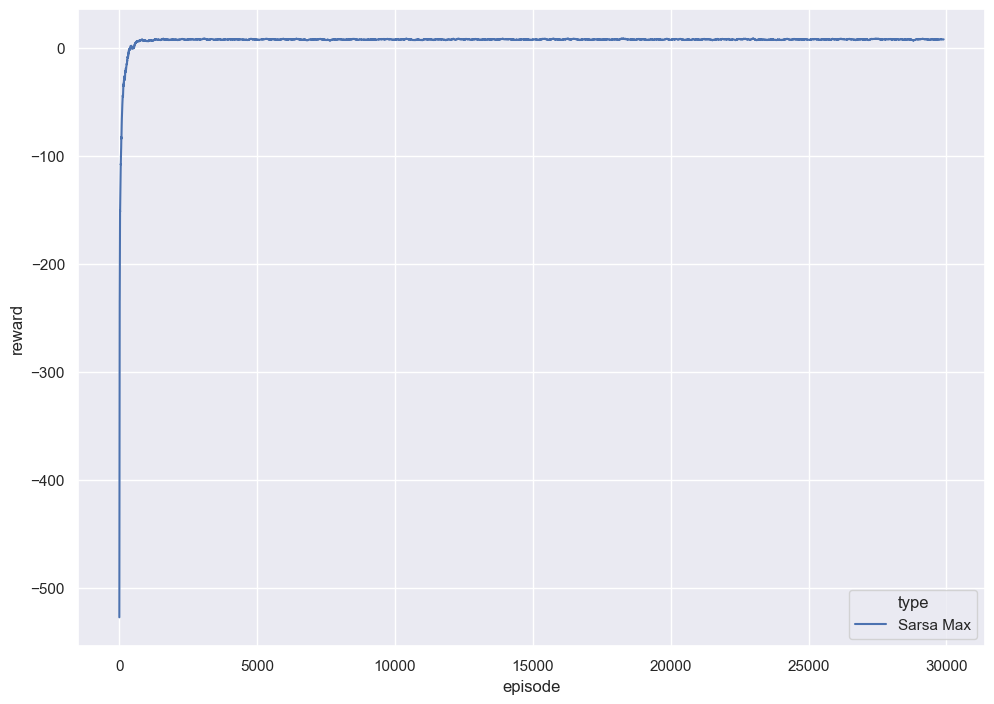

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='reward', hue='type',data = data)
sns_plot.figure.savefig("tax1v3.png")

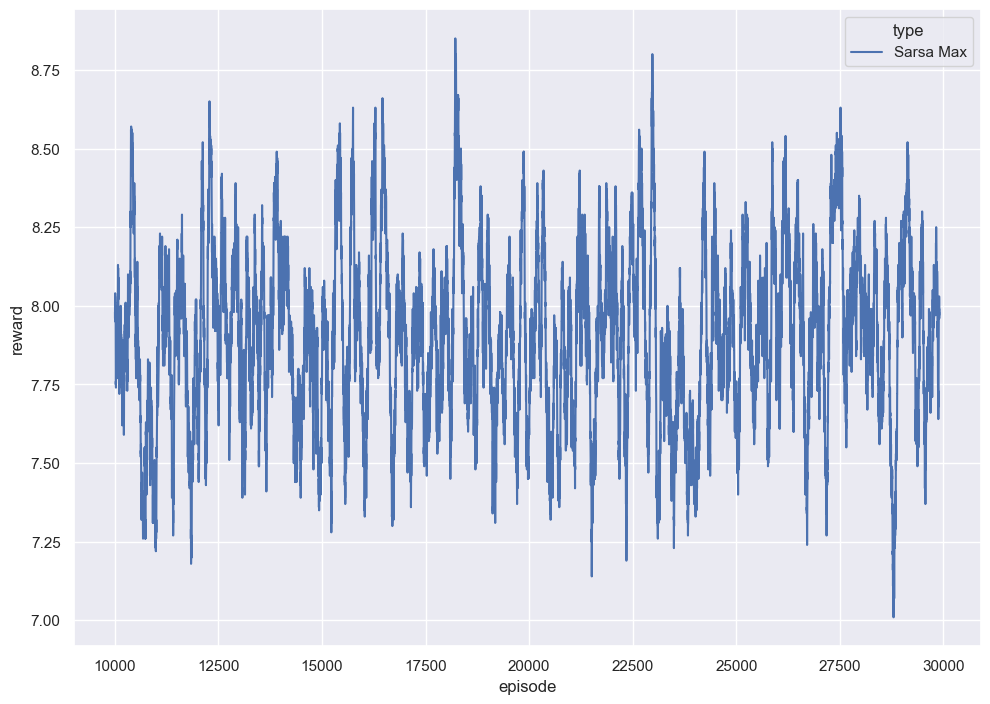

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='reward', hue='type',data = data[data.episode>10000])
sns_plot.figure.savefig("tax1v3.png")